In [29]:
%load_ext autoreload
%autoreload 2
from collections import Counter
from itertools import combinations
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
# from sklearn 
import xgboost as xgb
import matplotlib.pyplot as plt

import fitz
from par_seg import get_par_text
from helper import get_all_acts, has_act

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
doc = fitz.open('pdf/2020_04_30.pdf')
pars = get_par_text(doc)
len(pars)

355

In [3]:
%%time
df = pd.DataFrame({
    'X': pars,
    'y': map(has_act, pars)
})
df.y.value_counts()

CPU times: user 1.18 s, sys: 1.33 ms, total: 1.18 s
Wall time: 1.18 s


False    334
True      21
Name: y, dtype: int64

In [4]:
%%time
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        num_class=2
    ))
])
pipe.fit(df.X, df.y);

CPU times: user 1.92 s, sys: 195 µs, total: 1.92 s
Wall time: 378 ms


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_class=2, num_parallel_tree=1,
                               objective='multi:softprob', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [5]:
%%time
metrics = [
    'f1_macro',
    'f1_micro',
    'f1_weighted',
    'accuracy',
    'balanced_accuracy'
]
cv = cross_validate(pipe, df.X, df.y, scoring=metrics)

CPU times: user 9.57 s, sys: 23.9 ms, total: 9.59 s
Wall time: 1.55 s


In [6]:
cv

{'fit_time': array([0.22884202, 0.38199663, 0.25254726, 0.21156764, 0.28018975]),
 'score_time': array([0.07102132, 0.02624059, 0.02705431, 0.02489638, 0.03042412]),
 'test_f1_macro': array([0.82598039, 0.68189964, 0.92486772, 0.82598039, 0.86753731]),
 'test_f1_micro': array([0.97183099, 0.85915493, 0.98591549, 0.97183099, 0.97183099]),
 'test_f1_weighted': array([0.96734328, 0.89259932, 0.98496162, 0.96734328, 0.96852008]),
 'test_accuracy': array([0.97183099, 0.85915493, 0.98591549, 0.97183099, 0.97183099]),
 'test_balanced_accuracy': array([0.75      , 0.92537313, 0.875     , 0.75      , 0.8       ])}

In [7]:
%%time
file_data = {
    'pdf/' '2020_04_03.pdf':None,
    'pdf/' '2020_04_30.pdf':None,
    'pdf/' '2018_12_03.pdf':None,
    'pdf/' '2_jan_2019.pdf':None,
    'pdf/' '22_jan_2019.pdf':None,
    'pdf/' '2001_11_01.pdf':None,
    'pdf/' '2002_11_04.pdf':None,
}
for fname in file_data:
    doc = fitz.open(fname)
    pars = get_par_text(doc)
    file_data[fname] = pd.DataFrame({
        'X': pars,
        'y': map(has_act, pars)
    })

CPU times: user 10.5 s, sys: 50.9 ms, total: 10.6 s
Wall time: 10.6 s


/home/leomaffei/.pyenv/versions/3.8.1/envs/pesquisa-unb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


pdf/2002_11_04.pdf
	f1: 0.00, acc: 1.00


/home/leomaffei/.pyenv/versions/3.8.1/envs/pesquisa-unb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


pdf/2001_11_01.pdf
	f1: 0.00, acc: 1.00
pdf/22_jan_2019.pdf
	f1: 0.96, acc: 0.99
pdf/2_jan_2019.pdf
	f1: 1.00, acc: 1.00
pdf/2018_12_03.pdf
	f1: 0.88, acc: 0.98
pdf/2020_04_30.pdf
	f1: 0.83, acc: 0.98
pdf/2020_04_03.pdf
	f1: 0.90, acc: 0.96
CPU times: user 1min 20s, sys: 45 ms, total: 1min 20s
Wall time: 13 s


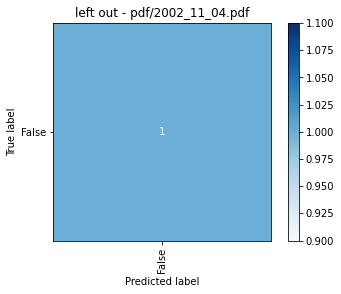

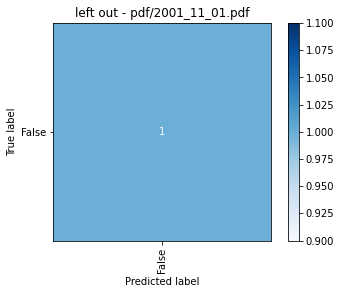

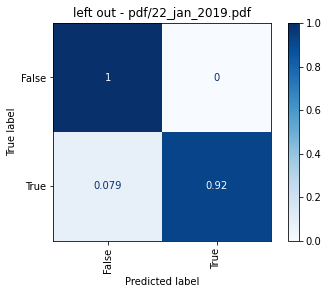

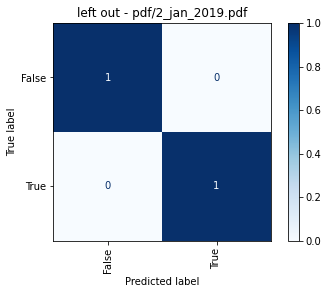

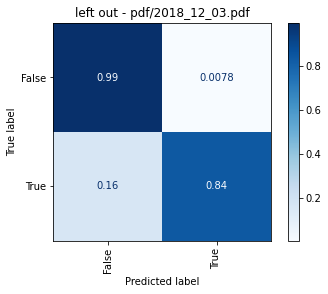

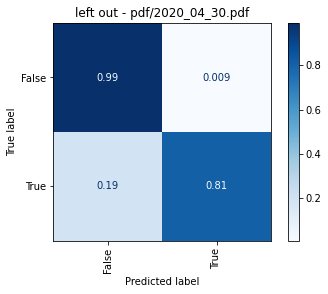

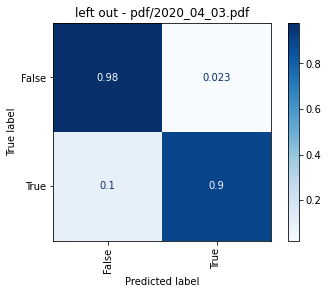

In [31]:
%%time
combs = combinations(file_data, len(file_data) - 1)
preds = {}
all_keys = set(file_data)
for c in combs:
    df = pd.concat(map(lambda x: file_data[x], c))
#     continue
    diff = list(all_keys - set(c))
    out = diff[0]
    pipe.fit(df.X, df.y);
    preds[out] = pipe.predict(file_data[out].X)
    X,y = list(zip(*file_data[out].values))
    disp = plot_confusion_matrix(pipe, X, y,
                            cmap=plt.cm.Blues,
                            normalize='true',
                            xticks_rotation='vertical',
                            )
    f1 = f1_score(y, preds[out])
    acc = accuracy_score(y, preds[out])
    print(out)
    print(f'\tf1: {f1:.2f}, acc: {acc:.2f}')
    disp.ax_.set_title(f'left out - {out}')

In [33]:
for k, v in preds.items():
    print(k)
    print('\t', Counter(v))
    print('\n\n')

pdf/2002_11_04.pdf
	 Counter({False: 212})



pdf/2001_11_01.pdf
	 Counter({False: 428})



pdf/22_jan_2019.pdf
	 Counter({False: 217, True: 35})



pdf/2_jan_2019.pdf
	 Counter({False: 10, True: 1})



pdf/2018_12_03.pdf
	 Counter({False: 778, True: 77})



pdf/2020_04_30.pdf
	 Counter({False: 335, True: 20})



pdf/2020_04_03.pdf
	 Counter({False: 219, True: 48})



